### Merton Jump-Diffusion model (1976)

#### 1.1 Basic theoretical background

The Merton Jump-Diffusion model is an extension of the Black-Scholes model that adds discrete jump process to the diffusion, allowing for the modeling of sudden market moves like crashes, rallies, or earnings surprises.

The model assumes that the asset price evolution is a combination of two stochastic processes:
- Continuous diffusion part (like in classical B-S)
- discrete jumps, which are modeled by Poisson process

The Merton model defines the asset price $S_t$ as following the stochastic differential equation (SDE):

$$ \frac{dS_t}{S_t} = (\mu - \lambda k) dt + \sigma dW_t + \left(\prod_{j=1}^{dN_t}Y_j - 1 \right) $$

Where:
- $\mu$: expected return
- $\sigma$: volatility
- $W_t$: Wiener process
- $N_t$: Poisson process with intensity $\lambda$:

$$ P\left(dN_t=k\right) = \frac{(\lambda dt)^k e^{-\lambda dt}}{k!} $$

- $Y_j$: jump multiplier, modeled by Log-Normal distribution with mean $\mu_y$ and variance $\sigma_y^2$; when a j-th jump occurs, the price changes by a factor of $Y_j$. We assume that the variance and the mean of $Y_j$ are the same for all $j$.
- $k$: average jump size correction (used to offset the drift from the Poisson process so that it remains arbitrage-free):

$$ k = \mathbb{E}\left[\prod_{j=1}^{dN_t}Y_j - 1\right] = e^{n\mu_y+\frac{n}{2}\sigma_y^2}-1 $$

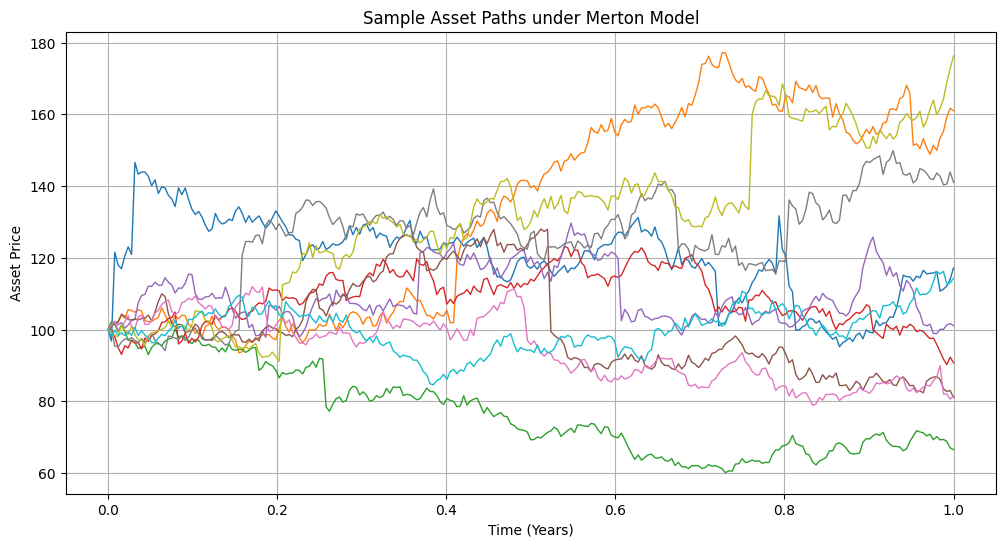

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters
S0 = 100.0         # Initial asset price
sigma = 0.25       # Initial variance
r = 0.2            # Risk-free rate

T = 1.0            # Time horizon
N = 252            # Time steps
M = 100000         # Number of paths

lambd = 5          # Jump intensity (jumps per year)
mu_j = 0.00        # Mean jump size (in log)
sigma_j = 0.1      # Volatility of jump size

dt = T / N

S_merton = np.full(shape=(N + 1, M), fill_value=S0)

for n in range(N):
    jumps = np.random.poisson(lambd * dt, M)
    jump_sizes = np.ones(M)

    Z_jumps = np.random.randn(M)

    for i in range(M):
        for num in range(jumps[i]):
            jump_sizes[i] = jump_sizes[i] * np.exp(mu_j + sigma_j * Z_jumps[i])

    jump_sizes = jump_sizes - np.ones(M)

    Z = np.random.randn(M)

    drift = (r - 0.5 * sigma**2 - lambd * (np.exp(jumps * mu_j + 0.5 * jumps * sigma_j**2) - 1)) * dt
    diffusion = sigma * np.sqrt(dt) * Z
    S_merton[n+1] = S_merton[n] + S_merton[n] * (drift + diffusion + jump_sizes)

plt.figure(figsize=(12,6))
for i in range(10):
    plt.plot(np.linspace(0, T, N+1), S_merton[:, i], lw=1)
plt.title('Sample Asset Paths under Merton Model')
plt.xlabel('Time (Years)')
plt.ylabel('Asset Price')
plt.grid(True)
plt.show()

#### 1.2 Distribution of log returns of asset prices

Historical data shows that Log-Normal distribution of asset price, predicted by B-S, underestimates the risk of big gains or losses:

<p align="center">
  <img src="figures/log-SP500-retn-vs-normal.jpg" width="800">
</p>

As we will see, the presence of sudden jumps in Merton model makes the tails of original Log-Normal distribution fatter.

In [9]:
# Additional Parameters
S0 = 100.0         # Initial asset price
v0 = sigma**2      # Initial variance
kappa = 3.0        # Rate of mean reversion
theta = sigma**2   # Long-run variance
xi = 0.7           # Vol of vol
rho = -0.7         # Correlation

def heston_model(S0, v0, rho, kappa, theta, xi, T, N, M):

    dt = T / N

    S = np.full(shape=(N + 1, M), fill_value=S0)
    v = np.full(shape=(N + 1, M), fill_value=v0)

    mu = np.array([0, 0])
    cov = np.array([[1, rho], 
                    [rho, 1]])

    Z = np.random.multivariate_normal(mu, cov, (N, M))

    for n in range(N):
        S[n + 1] = S[n] + r * S[n] * dt + np.sqrt(v[n] * dt) * S[n] * Z[n, :, 0]
        v[n + 1] = np.maximum(v[n] + kappa * (theta - v[n]) * dt + xi * np.sqrt(v[n] * dt) * Z[n, :, 1], 0) # Add truncation

    return S, v

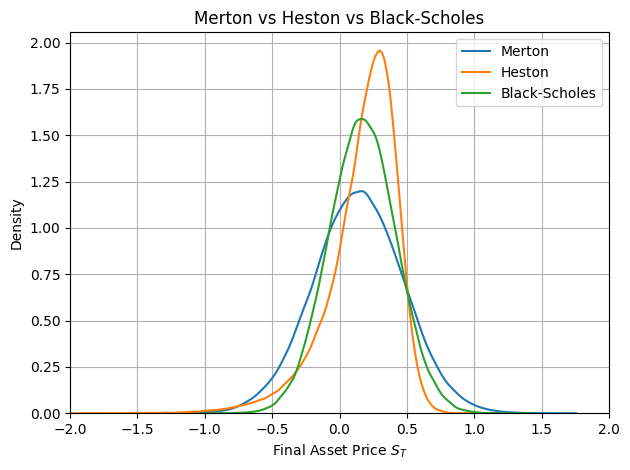

In [10]:
S_gbm = S0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * np.random.randn(M))

S_heston, _ = heston_model(S0, v0, rho, kappa, theta, xi, T, N, M)

sns.kdeplot(data=np.log(S_merton[-1] / S0), label=rf"Merton")
sns.kdeplot(data=np.log(S_heston[-1] / S0), label=rf"Heston")
sns.kdeplot(data=np.log(S_gbm / S0), label="Black-Scholes")

plt.xlabel('Final Asset Price $S_T$')
plt.ylabel('Density')
plt.xlim(-2, 2)
plt.title(rf"Merton vs Heston vs Black-Scholes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Bates's Stochastic Volatility Jump Diffusion (SVJD) model

Stochastic volatility jump diffusion model SVDJ was proposed by Bates in 1996, which is a combination of a Heston's stochastic volatility model with random jumps as in Merton's model:

$$
\begin{cases}
dS_t / S_t = (\mu - \lambda k)\, dt + \sqrt{\nu_t} \, dW_t^S + \left(\prod_{j=1}^{dN_t}Y_j - 1 \right)\\
d\nu_t = \kappa (\theta - v_t) \, dt + \xi \sqrt{\nu_t} \, dW_t^v\\
dW_t^S \cdot dW_t^v = \rho \, dt\\
P\left(dN_t=1\right) = \lambda dt
\end{cases}
$$

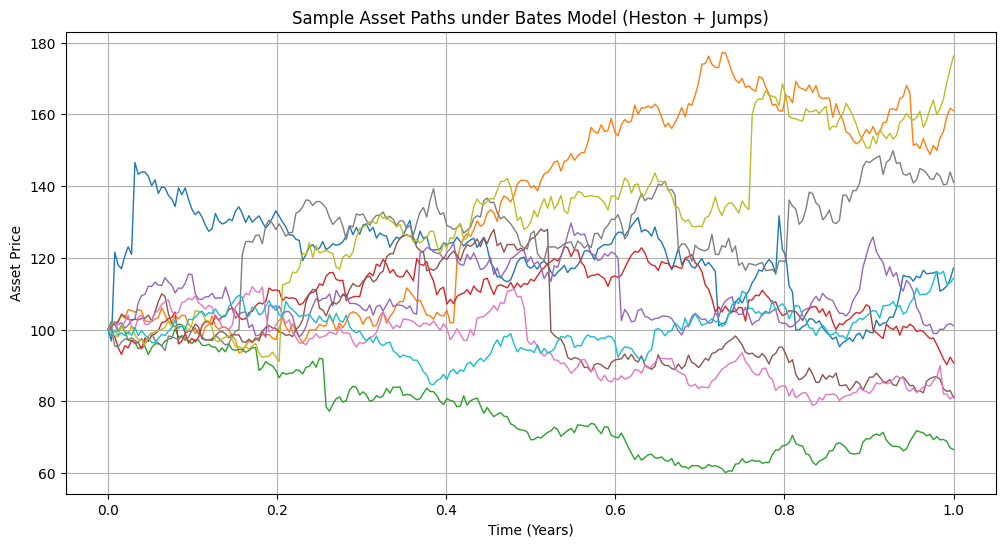

In [11]:
S_bates = np.full(shape=(N + 1, M), fill_value=S0)
v_bates = np.full(shape=(N + 1, M), fill_value=v0)

mu = np.array([0, 0])
cov = np.array([[1, rho], 
                [rho, 1]])

Z = np.random.multivariate_normal(mu, cov, (N, M))

for n in range(N):

    v_bates[n + 1] = np.maximum(v_bates[n] + kappa * (theta - v_bates[n]) * dt + xi * np.sqrt(v_bates[n] * dt) * Z[n, :, 1], 0) # Add truncation

    jumps = np.random.poisson(lambd * dt, M)
    jump_sizes = np.ones(M)

    Z_jumps = np.random.randn(M)

    for i in range(M):
        for num in range(jumps[i]):
            jump_sizes[i] = jump_sizes[i] * np.exp(mu_j + sigma_j * Z_jumps[i])

    jump_sizes = jump_sizes - np.ones(M)

    drift = (r - 0.5 * v_bates[n] - lambd * (np.exp(jumps * mu_j + 0.5 * jumps * sigma_j**2) - 1)) * dt
    diffusion = np.sqrt(v_bates[n]) * np.sqrt(dt) * Z[n, :, 0]
    S_bates[n+1] = S_bates[n] + S_bates[n] * (drift + diffusion + jump_sizes)

plt.figure(figsize=(12,6))
for i in range(10):
    plt.plot(np.linspace(0, T, N+1), S_merton[:, i], lw=1)
plt.title('Sample Asset Paths under Bates Model (Heston + Jumps)')
plt.xlabel('Time (Years)')
plt.ylabel('Asset Price')
plt.grid(True)
plt.show()

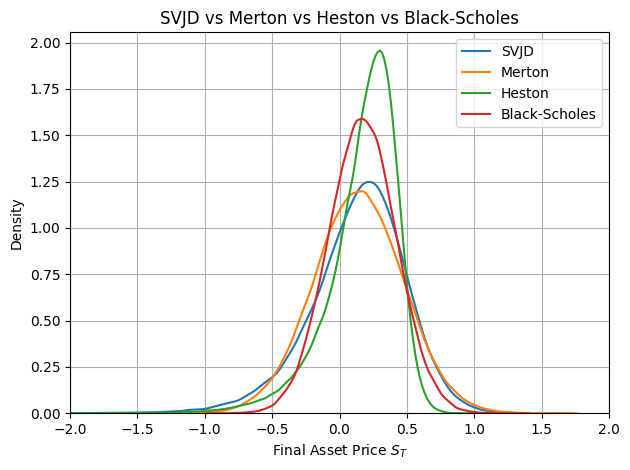

In [12]:
sns.kdeplot(data=np.log(S_bates[-1] / S0), label=rf"SVJD")
sns.kdeplot(data=np.log(S_merton[-1] / S0), label=rf"Merton")
sns.kdeplot(data=np.log(S_heston[-1] / S0), label=rf"Heston")
sns.kdeplot(data=np.log(S_gbm / S0), label="Black-Scholes")

plt.xlabel('Final Asset Price $S_T$')
plt.ylabel('Density')
plt.xlim(-2, 2)
plt.title(rf"SVJD vs Merton vs Heston vs Black-Scholes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()